In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

In [8]:
clinical_df = pd.read_csv('clinical.tsv', sep='\t', index_col=0).T
mirna_df = pd.read_csv('mirna.tsv', sep='\t', index_col=0).T

# Объединение данных
mirna_data = mirna_df.merge(clinical_df, left_index=True, right_index=True, how='inner')

# Список всех miRNA
mirnas = [col for col in mirna_df.columns if col.startswith('hsa-')]

# Повторение анализа для получения значимых микроРНК (из вашего ноутбука)
from scipy.stats import mannwhitneyu, spearmanr
from statsmodels.stats.multitest import multipletests

In [9]:
# 1. T-stage (T2 vs T3/T4)
t_stage_results = []
for mirna in mirnas:
    group_t2 = mirna_data[mirna_data['pathology_T_stage'] == 't2'][mirna].dropna()
    group_t3t4 = mirna_data[mirna_data['pathology_T_stage'].isin(['t3', 't4'])][mirna].dropna()
    if len(group_t2) > 1 and len(group_t3t4) > 1:
        stat, p_value = mannwhitneyu(group_t2, group_t3t4)
        mean_t2, mean_t3t4 = group_t2.mean(), group_t3t4.mean()
        fold_change = mean_t3t4 / mean_t2 if mean_t2 != 0 else float('inf')
        t_stage_results.append({
            'miRNA': mirna,
            'p_value': p_value,
            'fold_change': fold_change,
            'mean_t2': mean_t2,
            'mean_t3t4': mean_t3t4
        })

t_stage_df = pd.DataFrame(t_stage_results)
_, pvals_corrected_t, _, _ = multipletests(t_stage_df['p_value'].values, method='fdr_bh')
t_stage_df['p_value_corrected'] = pvals_corrected_t
t_stage_significant = t_stage_df[t_stage_df['p_value_corrected'] < 0.05].sort_values('p_value_corrected')

In [11]:
# 2. N-stage (N0 vs N1)
n_stage_results = []
for mirna in mirnas:
    group_n0 = mirna_data[mirna_data['pathology_N_stage'] == 'n0'][mirna].dropna()
    group_n1 = mirna_data[mirna_data['pathology_N_stage'] == 'n1'][mirna].dropna()
    if len(group_n0) > 1 and len(group_n1) > 1:
        stat, p_value = mannwhitneyu(group_n0, group_n1)
        mean_n0, mean_n1 = group_n0.mean(), group_n1.mean()
        fold_change = mean_n1 / mean_n0 if mean_n0 != 0 else float('inf')
        n_stage_results.append({
            'miRNA': mirna,
            'p_value': p_value,
            'fold_change': fold_change,
            'mean_n0': mean_n0,
            'mean_n1': mean_n1
        })

n_stage_df = pd.DataFrame(n_stage_results)
_, pvals_corrected_n, _, _ = multipletests(n_stage_df['p_value'].values, method='fdr_bh')
n_stage_df['p_value_corrected'] = pvals_corrected_n
n_stage_significant = n_stage_df[n_stage_df['p_value_corrected'] < 0.05].sort_values('p_value_corrected')

In [10]:
# 3. Корреляция с number_of_lymph_nodes
lymph_corr_results = []
for mirna in mirnas:
    data = mirna_data[[mirna, 'number_of_lymph_nodes']].dropna()
    if len(data) > 1:
        corr, p_value = spearmanr(data[mirna], data['number_of_lymph_nodes'])
        lymph_corr_results.append({
            'miRNA': mirna,
            'spearman_corr': corr,
            'p_value': p_value
        })

lymph_corr_df = pd.DataFrame(lymph_corr_results)
_, pvals_corrected_lymph, _, _ = multipletests(lymph_corr_df['p_value'].values, method='fdr_bh')
lymph_corr_df['p_value_corrected'] = pvals_corrected_lymph
lymph_corr_significant = lymph_corr_df[lymph_corr_df['p_value_corrected'] < 0.05].sort_values('p_value_corrected')


In [12]:
# Объединение значимых микроРНК
significant_mirnas = list(set(t_stage_significant['miRNA'].tolist() +
                             n_stage_significant['miRNA'].tolist() +
                             lymph_corr_significant['miRNA'].tolist()))
print(f"Всего значимых микроРНК: {len(significant_mirnas)}")

Всего значимых микроРНК: 83


In [13]:
# Подготовка данных для модели
X = mirna_data[significant_mirnas].dropna()
y_t_stage = mirna_data.loc[X.index, 'pathology_T_stage'].map({'t2': 0, 't3': 1, 't4': 1}).dropna()
y_n_stage = mirna_data.loc[X.index, 'pathology_N_stage'].map({'n0': 0, 'n1': 1}).dropna()

In [15]:
# Убедимся, что X и y имеют одинаковые индексы
X_t = X.loc[y_t_stage.index]
X_n = X.loc[y_n_stage.index]

In [16]:
# Нормализация данных
scaler = StandardScaler()
X_t_scaled = scaler.fit_transform(X_t)
X_n_scaled = scaler.fit_transform(X_n)

In [17]:
# Разделение данных
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t_scaled, y_t_stage, test_size=0.2, random_state=42)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n_scaled, y_n_stage, test_size=0.2, random_state=42)

In [18]:
# Обучение модели для T-stage
rf_t = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_search_t = GridSearchCV(rf_t, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_t.fit(X_train_t, y_train_t)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [19]:
# Оценка модели
y_pred_t = grid_search_t.predict(X_test_t)
print("T-stage модель:")
print(f"Лучшие параметры: {grid_search_t.best_params_}")
print(f"Точность: {accuracy_score(y_test_t, y_pred_t):.2f}")
print(f"AUC-ROC: {roc_auc_score(y_test_t, grid_search_t.predict_proba(X_test_t)[:, 1]):.2f}")
print(f"F1-мера: {f1_score(y_test_t, y_pred_t):.2f}")

T-stage модель:
Лучшие параметры: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Точность: 0.68
AUC-ROC: 0.71
F1-мера: 0.77


In [20]:
# Обучение модели для N-stage
rf_n = RandomForestClassifier(random_state=42)
grid_search_n = GridSearchCV(rf_n, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_n.fit(X_train_n, y_train_n)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [21]:
# Оценка модели
y_pred_n = grid_search_n.predict(X_test_n)
print("\nN-stage модель:")
print(f"Лучшие параметры: {grid_search_n.best_params_}")
print(f"Точность: {accuracy_score(y_test_n, y_pred_n):.2f}")
print(f"AUC-ROC: {roc_auc_score(y_test_n, grid_search_n.predict_proba(X_test_n)[:, 1]):.2f}")
print(f"F1-мера: {f1_score(y_test_n, y_pred_n):.2f}")


N-stage модель:
Лучшие параметры: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Точность: 0.86
AUC-ROC: 0.80
F1-мера: 0.00


In [22]:
# Извлечение важности признаков
feature_importance_t = pd.DataFrame({
    'miRNA': significant_mirnas,
    'importance': grid_search_t.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance_n = pd.DataFrame({
    'miRNA': significant_mirnas,
    'importance': grid_search_n.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

print("\nТоп-10 микроРНК для T-stage:")
print(feature_importance_t.head(10))
print("\nТоп-10 микроРНК для N-stage:")
print(feature_importance_n.head(10))


Топ-10 микроРНК для T-stage:
             miRNA  importance
26  hsa-mir-133a-1    0.038214
41    hsa-mir-3676    0.032333
59     hsa-mir-30a    0.028089
48   hsa-mir-1274b    0.025787
60    hsa-mir-891a    0.024884
70    hsa-mir-133b    0.022991
35     hsa-mir-592    0.022699
65     hsa-mir-222    0.018522
67     hsa-mir-145    0.018038
68     hsa-mir-221    0.017853

Топ-10 микроРНК для N-stage:
             miRNA  importance
27    hsa-mir-3614    0.032724
54    hsa-mir-1262    0.031844
12      hsa-mir-21    0.022324
5      hsa-mir-210    0.021433
14     hsa-mir-582    0.020385
62     hsa-mir-451    0.019597
19     hsa-mir-425    0.019209
51     hsa-mir-1-2    0.018692
33  hsa-mir-3926-1    0.018320
66     hsa-mir-653    0.018193


In [23]:
# Сохранение кандидатов
candidates = pd.concat([feature_importance_t.head(10), feature_importance_n.head(10)]).drop_duplicates()
candidates.to_csv('mirna_candidates.csv', index=False)

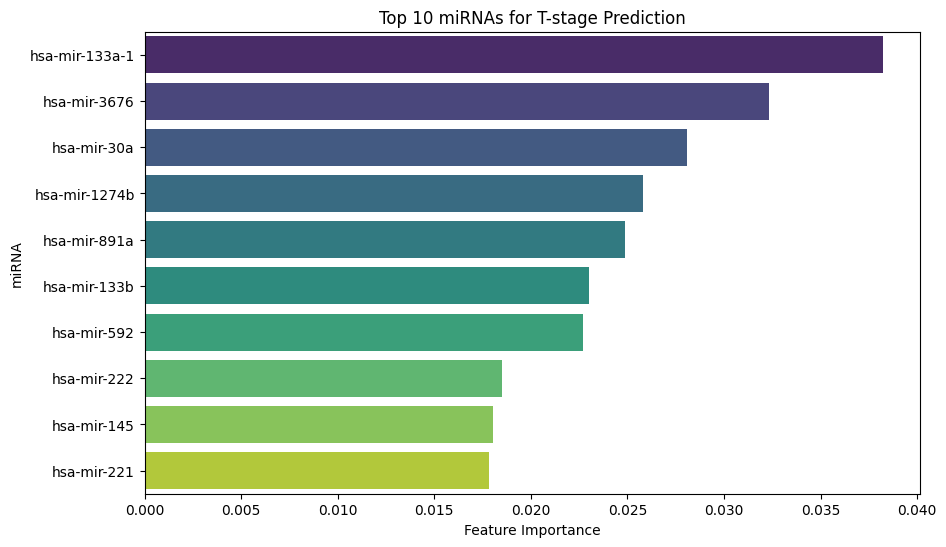

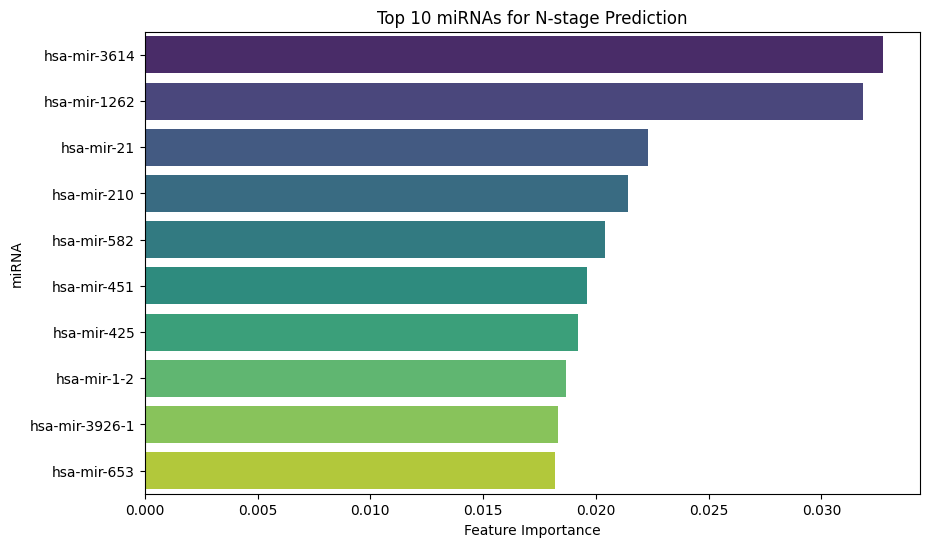

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='miRNA', hue='miRNA', data=feature_importance_t.head(10), palette='viridis', legend=False)
plt.title('Top 10 miRNAs for T-stage Prediction')
plt.xlabel('Feature Importance')
plt.ylabel('miRNA')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='miRNA', hue='miRNA', data=feature_importance_n.head(10), palette='viridis', legend=False)
plt.title('Top 10 miRNAs for N-stage Prediction')
plt.xlabel('Feature Importance')
plt.ylabel('miRNA')
plt.show()